implementation of the pizza with friend problem

In [82]:
import heapq
from collections import Counter


class PriorityQueue:
    """A basic Priority Queue with simple performance optimizations"""

    def __init__(self):
        self._data_heap = list()
        self._data_set = set()

    def __bool__(self):  # True if not empty
        return bool(self._data_set)

    def __contains__(self, item): # True if item is present
        return item in self._data_set

    def push(self, item, p=None): # no duplicated element, items with same priority works as a fifo
        assert item not in self, f"Duplicated element"
        if p is None:
            p = len(self._data_set)
        self._data_set.add(item)
        heapq.heappush(self._data_heap, (p, item))

    def pop(self): # retrieve the first element in priority order (smaller p first), same priority -> fifo
        p, item = heapq.heappop(self._data_heap)
        self._data_set.remove(item)
        return item


class Multiset:
    """Multiset"""

    def __init__(self, init=None):
        self._data = Counter()
        if init:
            for item in init:
                self.add(item)

    def __contains__(self, item):
        return item in self._data and self._data[item] > 0

    def __getitem__(self, item):
        return self.count(item)

    def __iter__(self):
        return (i for i in sorted(self._data.keys()) for _ in range(self._data[i]))

    def __len__(self):
        return sum(self._data.values())

    def __copy__(self):
        t = Multiset()
        t._data = self._data.copy()
        return t

    def __str__(self):
        return f"M{{{', '.join(repr(i) for i in self)}}}"

    def __repr__(self):
        return str(self)

    def __or__(self, other: "Multiset"):
        tmp = Multiset()
        for i in set(self._data.keys()) | set(other._data.keys()):
            tmp.add(i, cnt=max(self[i], other[i]))
        return tmp

    def __and__(self, other: "Multiset"):
        return self.intersection(other)

    def __add__(self, other: "Multiset"):
        return self.union(other)

    def __sub__(self, other: "Multiset"):
        tmp = Multiset(self)
        for i, n in other._data.items():
            tmp.remove(i, cnt=n)
        return tmp

    def __eq__(self, other: "Multiset"):
        return list(self) == list(other)

    def __le__(self, other: "Multiset"):
        for i, n in self._data.items():
            if other.count(i) < n:
                return False
        return True

    def __lt__(self, other: "Multiset"):
        return self <= other and not self == other

    def __ge__(self, other: "Multiset"):
        return other <= self

    def __gt__(self, other: "Multiset"):
        return other < self

    def add(self, item, *, cnt=1):
        assert cnt >= 0, "Can't add a negative number of elements"
        if cnt > 0:
            self._data[item] += cnt

    def remove(self, item, *, cnt=1):
        assert item in self, f"Item not in collection"
        self._data[item] -= cnt
        if self._data[item] <= 0:
            del self._data[item]

    def count(self, item):
        return self._data[item] if item in self._data else 0

    def union(self, other: "Multiset"):
        t = Multiset(self)
        for i in other._data.keys():
            t.add(i, cnt=other[i])
        return t

    def intersection(self, other: "Multiset"): # return the intersection between two multiset, for duplicated elements the min count of the two is used
        t = Multiset()
        for i in self._data.keys():
            t.add(i, cnt=min(self[i], other[i]))
        return t

In [83]:
from itertools import product, combinations
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

In [84]:
NUM_C = 3
NUM_D = 3
SEATS = 2

assert NUM_C <= NUM_D, "starting node is not valid"

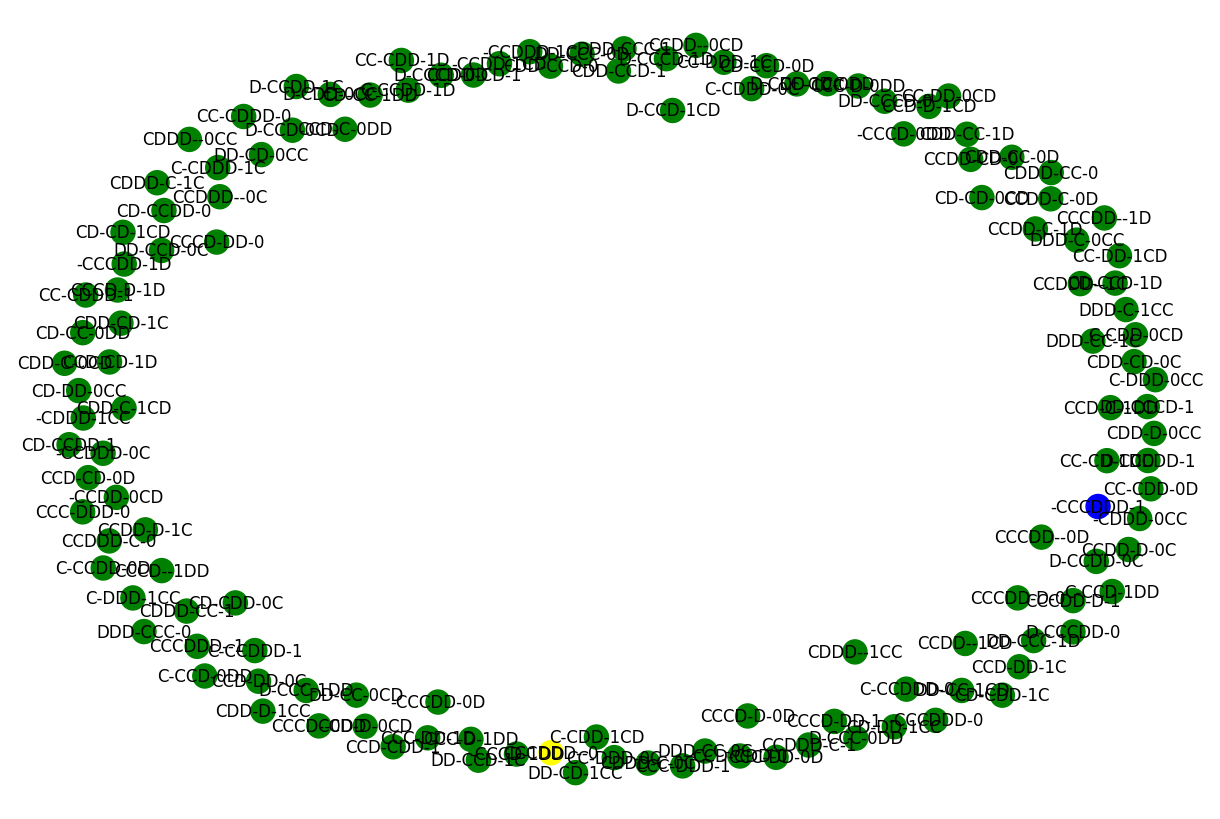

In [85]:
def node2sets(node): # string to pizzeria and pub multisets
    pizzeria, pub, bike = node.split("-")
    return Multiset(pizzeria), Multiset(pub), Multiset(bike)


def sets2node(pizzeria, pub, bike): # pizzeria and multisets to string
    return "".join(pizzeria) + "-" + "".join(pub) + "-" + "".join(bike)


SOURCE = "C" * NUM_C + "D" * NUM_D + "-" + "-0"
DESTINATION = "-" + "C" * NUM_C + "D" * NUM_D + "-1"


sspace = nx.Graph()
for c0, d0, c1, d1, cb, db, b in product(range(NUM_C + 1), range(NUM_D + 1), range(NUM_C + 1), range(NUM_D + 1), range(SEATS + 1), range(SEATS + 1), [True, False]):
    if (c0 + c1 + cb == NUM_C) and (d0 + d1 + db == NUM_D) and (cb + db <= SEATS):
        pizzeria = "C" * c0 + "D" * d0
        pub = "C" * c1 + "D" * d1
        bike = ("0" if b else "1") + "C" * cb + "D" * db
        if pizzeria + "-" + pub + "-" + bike == SOURCE:
          sspace.add_node(pizzeria + "-" + pub + "-" + bike, color= 'yellow')
        elif pizzeria + "-" + pub + "-" + bike == DESTINATION:
          sspace.add_node(pizzeria + "-" + pub + "-" + bike, color= 'blue')
        else: sspace.add_node(pizzeria + "-" + pub + "-" + bike, color= 'green')


colors = [node[1]['color'] for node in sspace.nodes(data=True)]
plt.figure(figsize=(12, 8))
nx.draw(sspace, node_color=colors, with_labels= True, font_color='black')

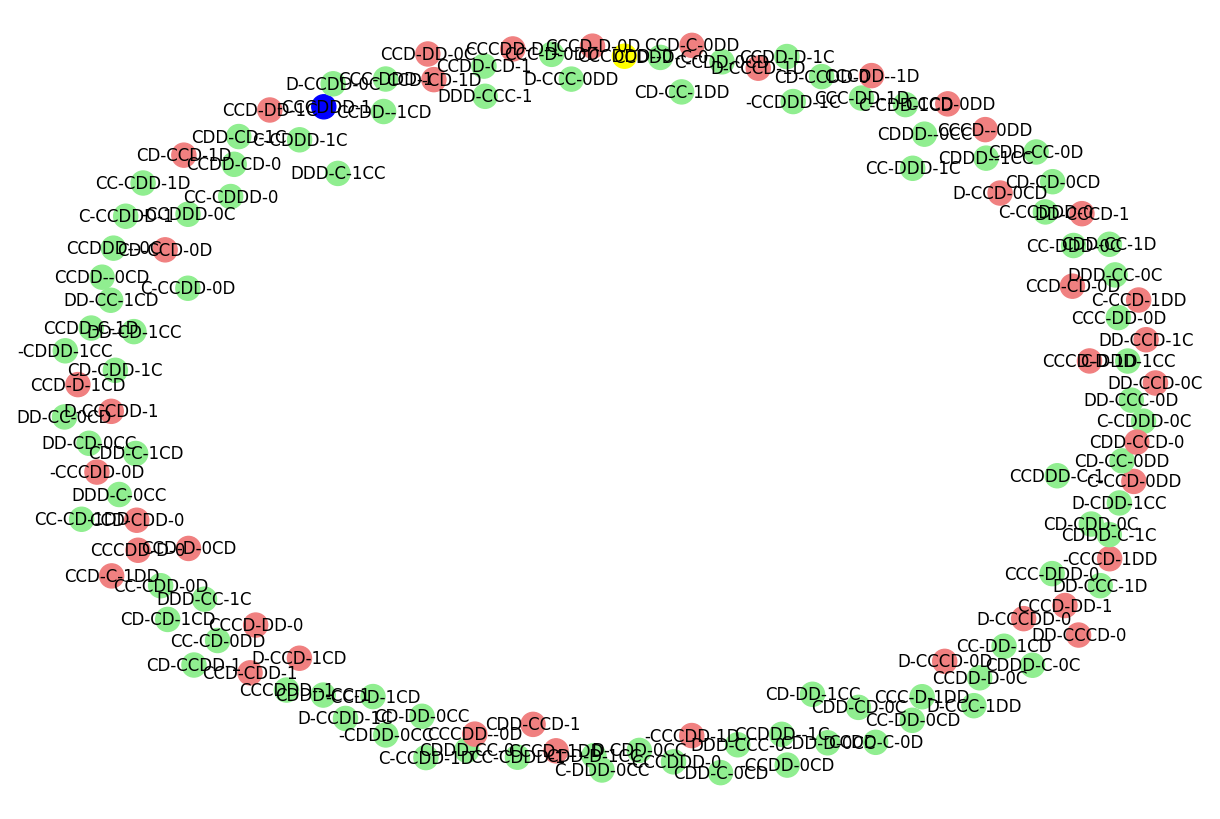

In [86]:
def valid_node(node): #take a node, split it to multisets and check if all is correct
    pizzeria, pub, bike = node2sets(node)
    return valid_location(pizzeria) and valid_location(pub) and (len(bike) - 1 <= SEATS) and (pizzeria.count('D') + pub.count('D') + bike.count('D') == NUM_D) and (pizzeria.count('C') + pub.count('C') + bike.count('C') == NUM_C)
    # doesn't need to check the bike (possibilities are DD, CC, C, D and empty)
    # but need to check if the total number of people is respected


def valid_location(loc): # definition of correctness
    if 0 < loc.count("D") < loc.count("C"): # more C than D -> bored to death (if there is at least a D to be bored)
        return False
    return True


plt.figure(figsize=(12, 8))
nx.draw(
    sspace,
    with_labels=True,
    node_color=["yellow" if n == SOURCE else "blue" if n == DESTINATION else "lightgreen" if valid_node(n) else "lightcoral" for n in sspace],
)

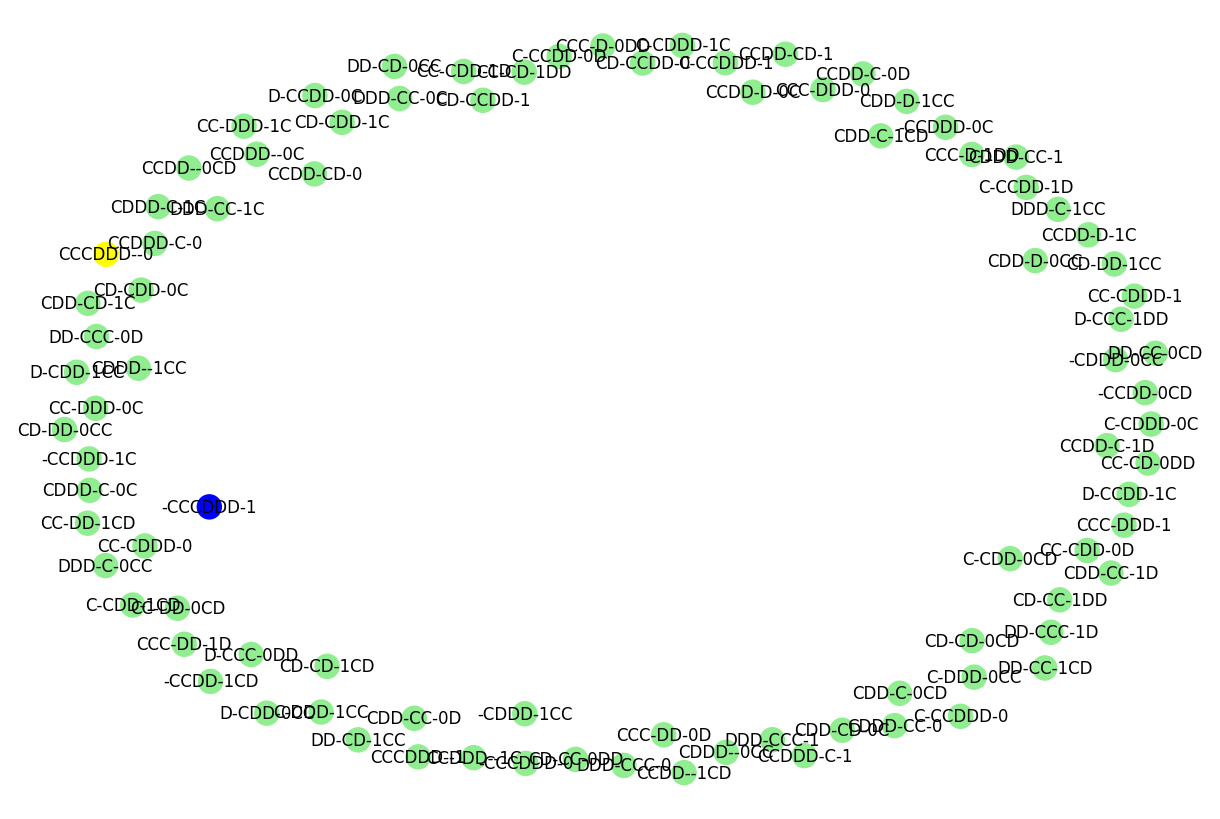

In [87]:
valid_sspace = nx.Graph()

for node in sspace.nodes:
    if valid_node(node):
        valid_sspace.add_node(node)

plt.figure(figsize=(12, 8))
nx.draw(
    valid_sspace,
    with_labels=True,
    node_color=["yellow" if n == SOURCE else "blue" if n == DESTINATION else "lightgreen" if valid_node(n) else "lightcoral" for n in valid_sspace],
)

<ipython-input-88-3aba89bf7b3c>:44: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which has known issues and is not actively maintained. Consider using nx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  nx.draw(valid_sspace, pos=graphviz_layout(valid_sspace), with_labels=True, node_color=node_color)


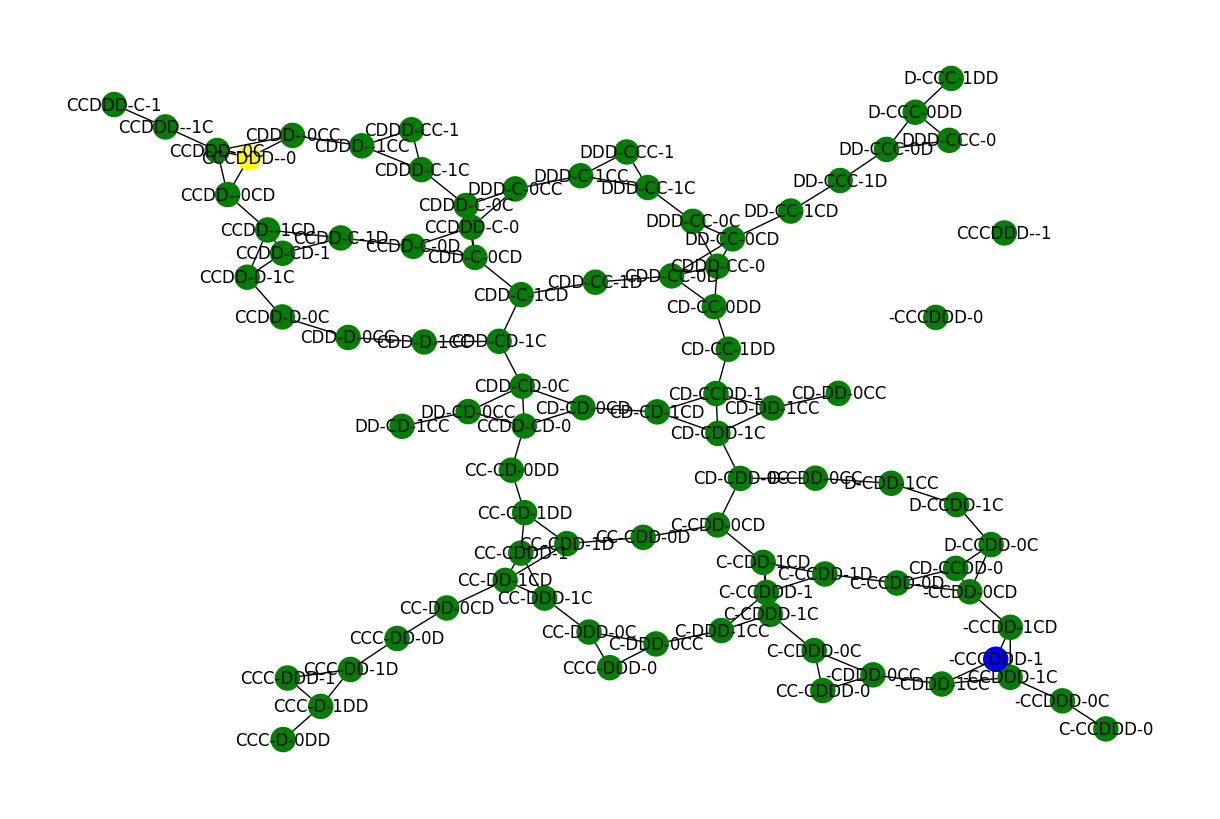

In [88]:
def get_b_range(nn):
    b_range = []
    for nc in range(nn + 1):
      for nd in range(nn + 1):
        if (0 < nc + nd <= nn):
          b_range.append("C" * nc + "D" * nd)
    return b_range

def change(pizzeria, pub, bike):
    possible = list()
    if bike.count('0'): # bike at pizzeria
        if len(bike) - 1 < SEATS: # if one person is on the bike
            for b in get_b_range(SEATS - (len(bike) - 1)):
                b = Multiset(b)
                if b <= pizzeria:
                    possible.append(sets2node(pizzeria - b, pub, bike + b))
                if b <= bike:
                    possible.append(sets2node(pizzeria + b, pub, bike - b))
        if len(bike) > 1: # bike not empty
            possible.append(sets2node(pizzeria, pub, bike - Multiset('0') + Multiset('1')))
    else: # bike at pub
        if len(bike) - 1 < SEATS: # if one person is on the bike
            for b in get_b_range(SEATS - (len(bike) - 1)):
                b = Multiset(b)
                if b <= pub:
                    possible.append(sets2node(pizzeria, pub - b, bike + b))
                if b <= bike:
                    possible.append(sets2node(pizzeria, pub + b, bike - b))
        if len(bike) > 1: # bike not empty
            possible.append(sets2node(pizzeria, pub, bike - Multiset('1') + Multiset('0')))
    return possible

valid_sspace = nx.Graph()

for node in sspace.nodes:
    if valid_node(node):
        valid_sspace.add_node(node)

for n1, n2 in [(a, b) for a in valid_sspace.nodes for b in change(*node2sets(a)) if valid_node(b)]:
    valid_sspace.add_edge(n1, n2)

plt.figure(figsize=(12, 8))
node_color = ["yellow" if n == SOURCE else "blue" if n == DESTINATION else "green" for n in valid_sspace]
nx.draw(valid_sspace, pos=graphviz_layout(valid_sspace), with_labels=True, node_color=node_color)

In [89]:
nx.shortest_path(valid_sspace, SOURCE, DESTINATION)

['CCCDDD--0',
 'CCDD--0CD',
 'CCDD--1CD',
 'CCDD-D-1C',
 'CCDD-D-0C',
 'CDD-D-0CC',
 'CDD-D-1CC',
 'CDD-CD-1C',
 'CDD-CD-0C',
 'CD-CD-0CD',
 'CD-CD-1CD',
 'CD-CDD-1C',
 'CD-CDD-0C',
 'D-CDD-0CC',
 'D-CDD-1CC',
 'D-CCDD-1C',
 'D-CCDD-0C',
 '-CCDD-0CD',
 '-CCDD-1CD',
 '-CCCDDD-1']